In [41]:
import pandas as pd
import numpy as np
import random
from IPython.display import display
import torchvision.models as models

import matplotlib.pyplot as plt
import itertools
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.cuda.amp import autocast, GradScaler

In [68]:
synthetic_df = pd.read_csv('../data/synthetic_dataset.csv')
synthetic_df.head(3)

,X_1,Y_1,Z_1,t_1,X_2,Y_2,Z_2,t_2,X_3,Y_3,...,X_35,Y_35,Z_35,t_35,X_36,Y_36,Z_36,t_36,theta,phi
0,-25.359,5.885,-6.684,78.875263,-37.609,5.885,-6.684,74.805427,-37.609,-7.315,...,-37.255,-39.545,-7.339,162.310989,-25.359,-39.545,-7.279,166.099271,35,100
1,-25.359,5.885,-6.684,78.359649,-37.609,5.885,-6.684,73.887611,-37.609,-7.315,...,-37.255,-39.545,-7.339,161.128345,-25.359,-39.545,-7.279,165.307207,35,101
2,-25.359,5.885,-6.684,77.810918,-37.609,5.885,-6.684,72.938039,-37.609,-7.315,...,-37.255,-39.545,-7.339,159.887916,-25.359,-39.545,-7.279,164.456034,35,102


In [69]:
def create_missing_data(data, num_clusters=9, cluster_size=4):
    np.random.seed(42)  # Для воспроизводимости
    num_samples = len(data)

    cluster_probs = [0.3, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1]
    cluster_counts = [1, 2, 3, 4, 5, 6, 7]

    new_columns = []
    for i in range(1, num_clusters * cluster_size + 1):
        new_columns.extend([f"A_{i}", f"X_{i}", f"Y_{i}", f"Z_{i}", f"t_{i}"])

    new_columns.extend(["theta", "phi"])

    new_data = pd.DataFrame(columns=new_columns)

    for idx in range(num_samples):
        num_active_clusters = np.random.choice(cluster_counts, p=cluster_probs)
        active_clusters = np.random.choice(
            range(1, num_clusters + 1), size=num_active_clusters, replace=False
        )
        active_stations = []
        for cluster in active_clusters:
            stations = list(
                range((cluster - 1) * cluster_size +
                      1, cluster * cluster_size + 1)
            )

            if np.random.rand() < 0.3:
                missed_station = np.random.choice(stations)
                stations.remove(missed_station)

            active_stations.extend(stations)

        row = []

        for station in range(1, num_clusters * cluster_size + 1):
            if station not in active_stations:
                row.append(-1)
                row.append(data.at[idx, f"X_{station}"])
                row.append(data.at[idx, f"Y_{station}"])
                row.append(data.at[idx, f"Z_{station}"])
                row.append(-1)
            else:

                row.append(1)
                row.append(data.at[idx, f"X_{station}"])
                row.append(data.at[idx, f"Y_{station}"])
                row.append(data.at[idx, f"Z_{station}"])
                row.append(data.at[idx, f"t_{station}"])

        row.append(data.at[idx, 'theta'])
        row.append(data.at[idx, 'phi'])

        new_data.loc[idx] = row

    return new_data

In [ ]:
synthetic_with_missing = create_missing_data(
    synthetic_df.copy(), num_clusters=9, cluster_size=4)

In [76]:
df = synthetic_with_missing.copy()
t_columns = [col for col in df.columns if col.startswith('t_')]

for col in t_columns:
    min_t = df[df[col] >= 0][col].min()
    df[col] = df[col].apply(lambda x: x - min_t if x >= 0 else x)

synthetic_with_missing.to_csv(
    '../data/synthetic_with_missing.csv', index=False)

In [77]:
data = pd.read_csv('../data/synthetic_with_missing.csv')
data.head(3)

,A_1,X_1,Y_1,Z_1,t_1,A_2,X_2,Y_2,Z_2,t_2,...,Y_35,Z_35,t_35,A_36,X_36,Y_36,Z_36,t_36,theta,phi
0,1.0,-25.359,5.885,-6.684,78.875263,1.0,-37.609,5.885,-6.684,74.805427,...,-39.545,-7.339,-1.0,-1.0,-25.359,-39.545,-7.279,-1.000000,35.0,100.0
1,1.0,-25.359,5.885,-6.684,78.359649,1.0,-37.609,5.885,-6.684,73.887611,...,-39.545,-7.339,-1.0,1.0,-25.359,-39.545,-7.279,165.307207,35.0,101.0
2,-1.0,-25.359,5.885,-6.684,-1.000000,-1.0,-37.609,5.885,-6.684,-1.000000,...,-39.545,-7.339,-1.0,-1.0,-25.359,-39.545,-7.279,-1.000000,35.0,102.0


In [78]:
zero_t_values = {}
for col in t_columns:
    zero_t_values[col] = data[data[col] == 0].index.tolist()
print(zero_t_values)

{'t_1': [], 't_2': [], 't_3': [], 't_4': [], 't_5': [], 't_6': [19, 21, 23, 24, 25, 26, 27, 28, 31, 34, 36, 41, 42, 44, 45, 46, 48, 49, 51, 53, 54, 60, 68, 162, 166, 172, 176, 179, 181, 182, 184, 188, 190, 191, 192, 195, 196, 200, 202, 206, 210, 212, 305, 312, 314, 316, 317, 319, 326, 327, 329, 332, 334, 335, 337, 338, 341, 343, 345, 346, 348, 354, 448, 455, 457, 468, 471, 475, 476, 477, 480, 481, 484, 487, 488, 489, 490, 491, 493, 591, 592, 595, 596, 597, 599, 604, 606, 608, 610, 612, 614, 617, 619, 621, 623, 629, 630, 635, 734, 736, 738, 742, 744, 750, 752, 753, 754, 755, 757, 759, 762, 766, 768, 769, 771, 772, 776, 778, 779, 877, 878, 880, 881, 882, 892, 896, 900, 905, 907, 909, 910, 912, 913, 915, 918, 920, 1027, 1028, 1030, 1035, 1036, 1038, 1042, 1043, 1044, 1045, 1047, 1054, 1055, 1057, 1058, 1059, 1060, 1163, 1170, 1175, 1179, 1181, 1183, 1185, 1186, 1190, 1191, 1192, 1193, 1198, 1203, 1204, 1306, 1309, 1311, 1312, 1313, 1315, 1316, 1317, 1319, 1324, 1327, 1329, 1339, 1340, 134

In [79]:
data.head()

,A_1,X_1,Y_1,Z_1,t_1,A_2,X_2,Y_2,Z_2,t_2,...,Y_35,Z_35,t_35,A_36,X_36,Y_36,Z_36,t_36,theta,phi
0,1.0,-25.359,5.885,-6.684,78.875263,1.0,-37.609,5.885,-6.684,74.805427,...,-39.545,-7.339,-1.0,-1.0,-25.359,-39.545,-7.279,-1.000000,35.0,100.0
1,1.0,-25.359,5.885,-6.684,78.359649,1.0,-37.609,5.885,-6.684,73.887611,...,-39.545,-7.339,-1.0,1.0,-25.359,-39.545,-7.279,165.307207,35.0,101.0
2,-1.0,-25.359,5.885,-6.684,-1.000000,-1.0,-37.609,5.885,-6.684,-1.000000,...,-39.545,-7.339,-1.0,-1.0,-25.359,-39.545,-7.279,-1.000000,35.0,102.0
3,-1.0,-25.359,5.885,-6.684,-1.000000,-1.0,-37.609,5.885,-6.684,-1.000000,...,-39.545,-7.339,-1.0,-1.0,-25.359,-39.545,-7.279,-1.000000,35.0,103.0
4,-1.0,-25.359,5.885,-6.684,-1.000000,-1.0,-37.609,5.885,-6.684,-1.000000,...,-39.545,-7.339,-1.0,-1.0,-25.359,-39.545,-7.279,-1.000000,35.0,104.0


In [80]:
features = data.drop(columns=['theta', 'phi'])
labels = data[['theta', 'phi']]

In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42)

In [82]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [83]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [84]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [86]:
class ImprovedCNNRegressor(nn.Module):
    def __init__(self):
        super(ImprovedCNNRegressor, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(
            in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.3)  # Dropout для регуляризации

        self.fc1 = nn.Linear(128 * 45, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = x.unsqueeze(1)  # Добавляем измерение для канала
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten

        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

In [87]:
model = ImprovedCNNRegressor()
model.to(device)

ImprovedCNNRegressor(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=5760, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

In [88]:
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scaler = GradScaler(device)

C:\Users\matsvei\AppData\Local\Temp\ipykernel_15632\2873452409.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(device)


In [89]:
def train_model(model, train_loader, criterion, optimizer, device, scaler):
    model.train()  # Переводим модель в режим тренировки
    running_loss = 0.0
    for batch_features, batch_labels in train_loader:
        # Переносим данные на нужное устройство
        batch_features, batch_labels = batch_features.to(
            device), batch_labels.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Используем autocast для более эффективных вычислений
        with autocast():
            # Прямой проход
            outputs = model(batch_features)
            # Вычисляем ошибку
            loss = criterion(outputs, batch_labels)

        # Масштабируем градиенты с помощью GradScaler
        scaler.scale(loss).backward()

        # Обновляем веса
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Train Loss: {epoch_loss:.4f}")
    return epoch_loss


def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Переводим модель в режим оценки
    running_loss = 0.0
    with torch.no_grad():  # Отключаем вычисление градиентов
        for batch_features, batch_labels in test_loader:
            # Переносим данные на нужное устройство
            batch_features, batch_labels = batch_features.to(
                device), batch_labels.to(device)

            # Прямой проход
            outputs = model(batch_features)

            # Вычисляем ошибку
            loss = criterion(outputs, batch_labels)

            running_loss += loss.item()

    epoch_loss = running_loss / len(test_loader)
    print(f"Test Loss: {epoch_loss:.4f}")
    return epoch_loss

In [90]:
def train_and_save_best_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    best_model_wts = None
    best_loss = float('inf')  # Начинаем с бесконечно большой ошибки
    # Инициализация GradScaler для использования с автоматическим смешиванием типов
    scaler = GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        # Тренировка с использованием autocast и GradScaler
        train_loss = train_model(
            model, train_loader, criterion, optimizer, device, scaler)

        # Оценка на тестовом наборе
        test_loss = evaluate_model(model, test_loader, criterion, device)

        # Сохраняем модель, если она показала наименьшую ошибку на тесте
        if test_loss < best_loss:
            best_loss = test_loss
            best_model_wts = model.state_dict()
            print(f"Best model at epoch {epoch+1} with loss: {test_loss:.4f}")

    # Загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model


# Функция для построения графика сравнения реальных и предсказанных значений
def plot_predictions(model, test_loader, device):
    model.eval()  # Переводим модель в режим оценки
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            # Прямой проход
            outputs = model(batch_features)

            # Собираем реальные и предсказанные метки
            true_labels.extend(batch_labels.cpu().numpy())
            predicted_labels.extend(outputs.cpu().numpy())

    # Преобразуем в одномерные массивы для удобства
    true_labels = np.array(true_labels).flatten()
    predicted_labels = np.array(predicted_labels).flatten()

    # Построение графика
    plt.figure(figsize=(10, 6))
    plt.plot(true_labels, predicted_labels, 'bo', label="Predicted vs Actual")
    plt.plot([true_labels.min(), true_labels.max()], [
             true_labels.min(), true_labels.max()], 'r-', label="Ideal line")
    plt.title("Predicted vs Actual (Test Data)")
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    plt.legend()
    plt.show()

In [91]:
model = train_and_save_best_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs, device)

C:\Users\matsvei\AppData\Local\Temp\ipykernel_15632\2033756956.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\matsvei\AppData\Local\Temp\ipykernel_15632\967990618.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/20
Train Loss: 28.4967
Test Loss: 17.5659
Best model at epoch 1 with loss: 17.5659
Epoch 2/20
Train Loss: 21.8462
Test Loss: 14.3000
Best model at epoch 2 with loss: 14.3000
Epoch 3/20
Train Loss: 20.3193
Test Loss: 14.6441
Epoch 4/20
Train Loss: 19.5425
Test Loss: 14.2803
Best model at epoch 4 with loss: 14.2803
Epoch 5/20
Train Loss: 19.0362
Test Loss: 17.9505
Epoch 6/20
Train Loss: 18.0242
Test Loss: 11.4445
Best model at epoch 6 with loss: 11.4445
Epoch 7/20
Train Loss: 17.1445
Test Loss: 12.1315
Epoch 8/20
Train Loss: 16.7428
Test Loss: 10.9244
Best model at epoch 8 with loss: 10.9244
Epoch 9/20
Train Loss: 16.6975
Test Loss: 10.5947
Best model at epoch 9 with loss: 10.5947
Epoch 10/20
Train Loss: 16.2816
Test Loss: 10.7476
Epoch 11/20
Train Loss: 16.4326
Test Loss: 10.0163
Best model at epoch 11 with loss: 10.0163
Epoch 12/20
Train Loss: 16.1633
Test Loss: 12.2361
Epoch 13/20
Train Loss: 16.3229
Test Loss: 9.2113
Best model at epoch 13 with loss: 9.2113
Epoch 14/20
Train 

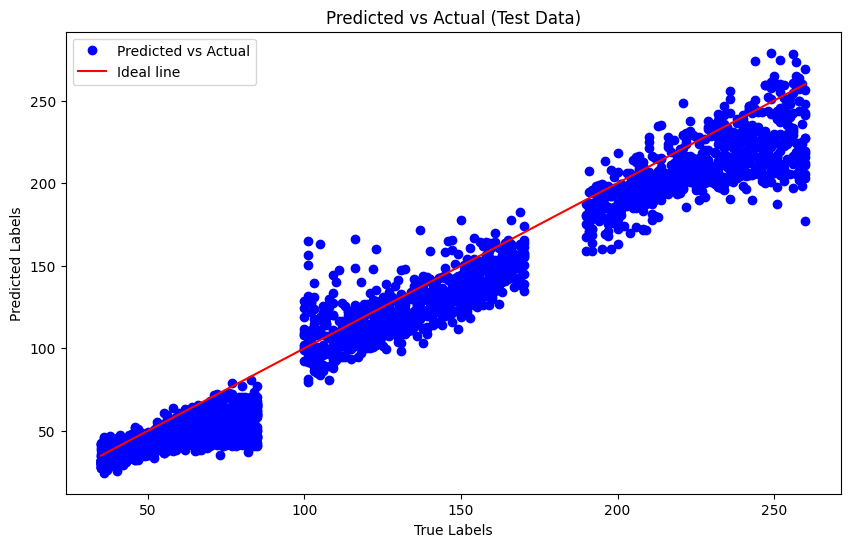

In [92]:
plot_predictions(model, test_loader, device)